## Iteration 2
---

Combined Code 4,5,6,7 from the lecture

### Target
- Add normalisation, regularisation, GAP.
- Increase the capacity after adding GAP, but not too much.
- Make it as light as possible without adding any normalisation, regularisation, etc.

### Results

- Parameters: 7.1k
- Best Train accuracy: 98.78
- Best Test accuracy: 99.30

### Analysis

- Normalisatoin, Dropout, GAP working.
- Highly potent model even with less parameters.
- Currently underfitting. Can be improved by training more.

In [1]:
!nvidia-smi

Sun Feb 19 11:47:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
SEED = 69

torch.manual_seed(SEED)

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [10]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.convblock1 = nn.Sequential(
            nn.Conv2d(1, 4, 3),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Dropout(dropout_value)
          ) # 28>26 | 3
        self.convblock2 = nn.Sequential(
            nn.Conv2d(4, 8, 3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(dropout_value)
          ) # 26 > 24 |  5
        self.convblock3 = nn.Sequential(
            nn.Conv2d(8, 8, 3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(dropout_value)
          ) # 24> 22 | 7
        self.pool2 = nn.MaxPool2d(2, 2) # 22 > 11 | 14
        self.convblock4 = nn.Sequential(
            nn.Conv2d(8, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
          ) #11 > 9 | 16
        self.convblock5 = nn.Sequential(
            nn.Conv2d(16, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
          ) # 9 > 7 | 18
        self.convblock6 = nn.Sequential(
            nn.Conv2d(16, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
          ) # 7 > 5 | 20
        self.convblock7 = nn.Sequential(
            nn.Conv2d(16, 10, 1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)

          ) # 5 > 5 | 24 | > 1x1x10

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool2(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)

        x = x.view(-1, 10) #1x1x10> 10
        return F.log_softmax(x, dim=-1)

In [11]:
!pip install torchsummary
from torchsummary import summary
device = torch.device("cuda" if cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              40
       BatchNorm2d-2            [-1, 4, 26, 26]               8
              ReLU-3            [-1, 4, 26, 26]               0
           Dropout-4            [-1, 4, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             296
       BatchNorm2d-6            [-1, 8, 24, 24]              16
              ReLU-7            [-1, 8, 24, 24]               0
           Dropout-8            [-1, 8, 24, 24]               0
            Conv2d-9            [-1, 8, 22, 22]             584
      BatchNorm2d-10            [-1, 8, 22, 22]              16
             ReLU-11            [-1, 8, 22, 22]               0
          Dropout-12            [-1, 8, 22, 22]               0

In [12]:
from tqdm import tqdm

train_losses = []
test_losses = []

train_acc = []
test_acc = []

def train(model, device, train_loader, optimiser):
  model.train()

  pbar = tqdm(train_loader)
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):

    data, target = data.to(device), target.to(device)

    optimiser.zero_grad()

    y_pred = model(data)

    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.item())

    loss.backward()
    optimiser.step()

    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
  model.eval()

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for data, target in test_loader:

      data, target = data.to(device), target.to(device)

      output = model(data)

      test_loss += F.nll_loss(output, target, reduction='sum').item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
  test_acc.append(100. * correct / len(test_loader.dataset))

In [13]:
model = Net().to(device)

optimiser = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15

for epoch in range(EPOCHS):
  print("epoch:", epoch)
  train(model, device, train_loader, optimiser)
  test(model, device, test_loader)

epoch: 0


Loss=0.19176654517650604 Batch_id=468 Accuracy=73.76: 100%|██████████| 469/469 [00:20<00:00, 22.73it/s]



Test set: Average loss: 0.1441, Accuracy: 9638/10000 (96.38%)

epoch: 1


Loss=0.08368613570928574 Batch_id=468 Accuracy=96.40: 100%|██████████| 469/469 [00:15<00:00, 31.17it/s]



Test set: Average loss: 0.1545, Accuracy: 9559/10000 (95.59%)

epoch: 2


Loss=0.17107154428958893 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:15<00:00, 31.12it/s]



Test set: Average loss: 0.0472, Accuracy: 9862/10000 (98.62%)

epoch: 3


Loss=0.15945808589458466 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:15<00:00, 30.69it/s]



Test set: Average loss: 0.0421, Accuracy: 9873/10000 (98.73%)

epoch: 4


Loss=0.04484567046165466 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:14<00:00, 31.39it/s]



Test set: Average loss: 0.0377, Accuracy: 9884/10000 (98.84%)

epoch: 5


Loss=0.034554529935121536 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:15<00:00, 29.78it/s]



Test set: Average loss: 0.0339, Accuracy: 9905/10000 (99.05%)

epoch: 6


Loss=0.09767977148294449 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:16<00:00, 28.87it/s]



Test set: Average loss: 0.0301, Accuracy: 9911/10000 (99.11%)

epoch: 7


Loss=0.01633566990494728 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:14<00:00, 31.47it/s]



Test set: Average loss: 0.0271, Accuracy: 9915/10000 (99.15%)

epoch: 8


Loss=0.11485597491264343 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:14<00:00, 31.59it/s]



Test set: Average loss: 0.0291, Accuracy: 9904/10000 (99.04%)

epoch: 9


Loss=0.0171059537678957 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:15<00:00, 29.66it/s]



Test set: Average loss: 0.0252, Accuracy: 9929/10000 (99.29%)

epoch: 10


Loss=0.08400610834360123 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:14<00:00, 31.55it/s]



Test set: Average loss: 0.0223, Accuracy: 9928/10000 (99.28%)

epoch: 11


Loss=0.03255357965826988 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:14<00:00, 31.38it/s]



Test set: Average loss: 0.0276, Accuracy: 9912/10000 (99.12%)

epoch: 12


Loss=0.04765865206718445 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:15<00:00, 30.62it/s]



Test set: Average loss: 0.0223, Accuracy: 9925/10000 (99.25%)

epoch: 13


Loss=0.02601250447332859 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:15<00:00, 31.17it/s]



Test set: Average loss: 0.0248, Accuracy: 9928/10000 (99.28%)

epoch: 14


Loss=0.01168071012943983 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:15<00:00, 31.23it/s]



Test set: Average loss: 0.0242, Accuracy: 9930/10000 (99.30%)



Text(0.5, 1.0, 'Test Accuracy')

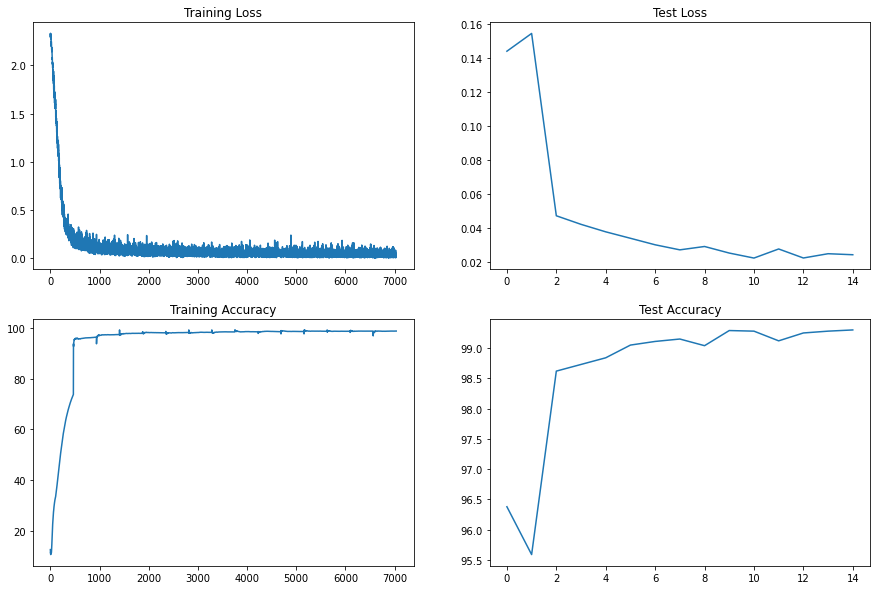

In [15]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")